In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji
import unidecode
from html import unescape
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.html.use_mathjax', False) # normalize fonts for pandas display
pd.options.display.max_colwidth = None

# custom functions
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# extract and examine the first ten rows of the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i/i_am_soooo_glad_im_not_circumcised/,self.jokes,NaN,My corona is covered with foreskin so it is not exposed to viruses.,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for recording your bowel movements?,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj/what_is_the_difference_between_my_wife_and_my/,self.jokes,NaN,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",What is the difference between my wife and my vacuum?,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh/my_last_joke_for_now/,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg/the_nintendo_64_turns_18_this_week/,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [7]:
# dataframe dimensions
df.shape

(1000000, 12)

In [8]:
# look at the text information and the reddit score
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [9]:
# description of score feature
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


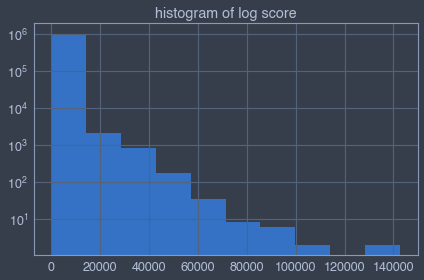

In [10]:
# score feature distribution
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [11]:
# define some parameters 
CLASS_SIZE = 100000
TRAIN_SIZE = 0.99
MIN_UPVOTES = 10
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 150
SELFTEXT_MAX_LEN = 500

In [12]:
# boolean masks
# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) 

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) 

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [13]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565332, 12)

In [14]:
print("what are NaNs?")
display(df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10))
df_cleaned = df_cleaned[~is_null]

what are NaNs?


,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [15]:
# removing escape character references  
escapes = ''.join([chr(char) for char in range(1,32)])

df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(str(x).translate(escapes)).split()))
display(df_cleaned[['title', 'selftext']].head())

,title,selftext
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
7,What did the French man say to the attractive teletubby?,Oo..lala...
10,Yo Mama,"Yo momma's so fat, that when she went to the zoo, the hippos got jealous."


In [16]:
# removing html character references  
PATTERN = r"[^a-z\s]?(&\S+;)[^a-z\s]?"

# get examples of instances containing pattern
print("samples instances containing pattern :")
html_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

# see changes
print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, " ", str(x)))
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. &amp;#x200B; ""Many moons pass, and chief Walking Horse no go number two."" He complains. &amp;#x200B; The doctor reaches into his cabinet and fishes out a mild laxative. &amp;#x200B; ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" &amp;#x200B; The chief took the little bottle, and left back to his village. &amp;#x200B; Two days later, ask the Doctor requested, he's back. &amp;#x200B; ""Chief Walking Horse, have you moved yet?"" &amp;#x200B; The chief slowly shakes his head no. &amp;#x200B; ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" &amp;#x200B; The chief nods his head yes, and leaves to return to his village. &amp;#x200B; This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. &amp;#x200B; A few days later, while visiting a close by settlement, the Doctor sees the Chief. &amp;#x200B; ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" &amp;#x200B; The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,&gt;!not like this !&lt;/ &gt;! not like this not like this !&lt;/&gt;! / not like this!&lt; &amp;#x200B; &gt;!not like this tooo!&lt; .&gt;!not like this also !&lt;&gt;!look somewhere else!&lt; &amp;#x200B; &gt;!Not like this either !&lt; . &gt;! not like this !&lt;.&gt;! not like this!&lt;
532,I touched my girlfriends ass and she farted.,&amp;#x200B; &amp;#x200B; It was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost. He would buy a map at any cost. One day on a trip, he heard his map rip, so into a trashcan, he tossed. &amp;#x200B; He wandered and wandered with no aim. He started to think it was a game. But with no end in sight and quickly losing light, he started back the way he came. &amp;#x200B; He cried and threw his hands in the air; he screamed and shouted with despair. ""Could anyone help?"" Then he started with a yelp. There was another man, but trust him, he dare? &amp;#x200B; ""I gotchu,"" the man said with a grin. ""Come on, I'll help you, hop in."" He got in his car, they drove pretty far: for the traveler, it seemed a big win. &amp;#x200B; The driver took the man to a club: he assumed there'd be a phone at a pub. So, in the men went, and a message to his wife, the traveler sent. Then at a deli next door, they ordered a sub. &amp;#x200B; Suddenly thirsty, the traveler got, so back to the club for drinks, he sought. He was bad at navigating, the driver was hating, but he pressed on, getting lost quite a lot. &amp;#x200B; At last, he found the club just fine, but he didn't want a beer or wine. He pushed through the crowd, and yelled out quite loud, ""Hey man, where's the punchline?"""


transformed instances :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. ""Many moons pass, and chief Walking Horse no go number two."" He complains. The doctor reaches into his cabinet and fishes out a mild laxative. ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" The chief took the little bottle, and left back to his village. Two days later, ask the Doctor requested, he's back. ""Chief Walking Horse, have you moved yet?"" The chief slowly shakes his head no. ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" The chief nods his head yes, and leaves to return to his village. This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. A few days later, while visiting a close by settlement, the Doctor sees the Chief. ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,not like this not like this not like this / not like this not like this tooo not like this also look somewhere else Not like this either . not like this not like this
532,I touched my girlfriends ass and she farted.,It was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost. He would buy a map at any cost. One day on a trip, he heard his map rip, so into a trashcan, he tossed. He wandered and wandered with no aim. He started to think it was a game. But with no end in sight and quickly losing light, he started back the way he came. He cried and threw his hands in the air; he screamed and shouted with despair. ""Could anyone help?"" Then he started with a yelp. There was another man, but trust him, he dare? ""I gotchu,"" the man said with a grin. ""Come on, I'll help you, hop in."" He got in his car, they drove pretty far: for the traveler, it seemed a big win. The driver took the man to a club: he assumed there'd be a phone at a pub. So, in the men went, and a message to his wife, the traveler sent. Then at a deli next door, they ordered a sub. Suddenly thirsty, the traveler got, so back to the club for drinks, he sought. He was bad at navigating, the driver was hating, but he pressed on, getting lost quite a lot. At last, he found the club just fine, but he didn't want a beer or wine. He pushed through the crowd, and yelled out quite loud, ""Hey man, where's the punchline?"""


In [17]:
# find and remove user edits:
PATTERN = "(?i)[^a-z](edit)\W.+"

# clean posts to change this ... 
print("samples instances containing pattern :")
edits_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[edits_idx][['title', 'selftext']].head())

# remove user edits added after user posted content
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x:re.sub(PATTERN, " ", x))

# into this ...
print("transformed instances :")
display(df_cleaned[['title', 'selftext']].loc[edits_idx].head())

samples instances containing pattern :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of. EDIT: IOW she didn't like sentences that ended in five prepositions.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."" *edit: spelling*"
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American. Edit: wording"
1096,A man with a COVID-19 walks into the bar,...and is told to leave. [edit]: I'm gonna go offline for 14 days for hating myself.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned. Edit: punch line


transformed instances :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."""
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American."
1096,A man with a COVID-19 walks into the bar,...and is told to leave.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned.


In [18]:
# remove contents in user added brackets
PATTERN = r"(\(.*?\))|(\[.*?\])|(\{.*?\})"

print("samples instances containing pattern :")
brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, "", x))
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage: (Read from bottom to top)
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches (so he gets $7.5M). Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: [tearing up] ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: [angry] ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: (sobbing) Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-r

transformed instances :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage:
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches . Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-rear floor mats, Height adjustable front seats, Isofix front passenger and r

In [19]:
### removing non-ascii chars 

# user emojis
PATTERN = r"[\U0001F600-\U0001F64F]"

print("samples instances containing pattern :")
brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: x.encode('ascii','ignore').decode('UTF-8'))
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away 😂😂😂 L😎L
12477,How the world has changed in 2020!,Feb 14: Will you be my Valentine ? . . . March 14: Will you be my Quarantine ? 🙂
14968,I need a nurse named Kate!,So I can take my mediKATion..... Ok im leaving im leaving. 😆
33425,Warning: Some viewers may find the following joke stupid and offensive. Discretion is advised,When I lived in Hawaii I caught a very bad case of yellow fever. I never did get the cure. The best I could do is pay for some over-the-counter medication. 😃😃😃
38499,I was uncertain if the superbowl halftime was good or not.,Too many hips and butts. Ifs and buts 😋


transformed instances :


,title,selftext
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away LL
12477,How the world has changed in 2020!,Feb 14: Will you be my Valentine ? . . . March 14: Will you be my Quarantine ?
14968,I need a nurse named Kate!,So I can take my mediKATion..... Ok im leaving im leaving.
33425,Warning: Some viewers may find the following joke stupid and offensive. Discretion is advised,When I lived in Hawaii I caught a very bad case of yellow fever. I never did get the cure. The best I could do is pay for some over-the-counter medication.
38499,I was uncertain if the superbowl halftime was good or not.,Too many hips and butts. Ifs and buts


In [20]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['title'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 0) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 0) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples available per class")

392645 samples available per class


### Filtering for relevent content

In [21]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(\sclick\s)|(\ssubs?\s)|(sub)?(reddit)|\S(vote)s?|(\sop\s)|https?\S+|([a-z]?(re)?post(?=(ed)|[^a-z]|$))|_|(voted\s)(?=(up|down))"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
display(df_cleaned[is_meta].sample(10)[['title', 'selftext', 'score']])
df_cleaned = df_cleaned[~is_meta]

,title,selftext,score
347409,I want sex that feels as good as taking a dump....,"It last half an hour, my legs are numb, and I can still browse Reddit.",17
594995,So i tried reddit's advice and ate a kiwi without taking the skin off.,It was good. Kept getting feathers stuck in my teeth though.,26
518895,Why can't mitochondria get dates?,Because they're all r/incels.,16
939805,brb reddit i gotta go do my chores,okay im back,0
421540,The election on the hot air balloon was great,Everyone upvoted,0
811941,"Hey, nice people of /r/Jokes. Can you give me max negative comment Karma?","I'll post a comment below, and I want you to downvote it until I have -100 comment Karma. I want you people to make me into a total joke. Thanks!",0
634689,How many Jokes subredditors does it take to change a lightbulb?,We'll find out in the comments.,7
522385,"If you've had sex with less than 536 people, then having sex with you is a more exclusive club than going into space.",I though I'd post something my ex-girlfriend could feel good about.,248
642551,This subreddit is definitely for the shits and giggles...,...until someone giggles and shits.,1
907635,At the Apple Store,"At the apple store talking with a sales guy: **Me:** I noticed you guys changed your shirts from blue to red, how come? **Sales guy:** I don't know, I think they just wanted to change it up. **Me:** Maybe it's because with red shirts you're...expendable. **Sales guy:** -_-",0


In [22]:
# offensive jokes
toxic_mispellings_dict = pd.read_pickle("helper_toxic_misspell_dict.pickle")
toxic_words_list = list(set([word.lower() for word in set(toxic_mispellings_dict.values())]))

def correct_toxic_mispellings(sentence, toxic_mispellings_dict):
    for word in sentence.split():
        if word in toxic_mispellings_dict.keys():
            sentence = sentence.replace(word, toxic_mispellings_dict[word])
    return sentence

df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: correct_toxic_mispellings(x, toxic_mispellings_dict))
is_toxic = df_cleaned['selftext'].str.contains("|".join(toxic_words_list)) | df_cleaned['title'].str.contains("|".join(toxic_words_list))
display(df_cleaned[is_toxic][['title', 'selftext']])
df_cleaned = df_cleaned[~is_toxic]

,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
30,Two guys are caught by cannibals,"They are sitting in the big pot as the cannibals are stoking the fire, adding water, potatoes, and other veggies. One of the men starts laughing. His friend says what is the matter with you we are about to be turned into stew and your laughing. I just shit in the gravy! Then the cannibals grant them three wishes and it turns into a different joke."
49,Two nuns are driving down a country lane late one night,"Suddenly, a vampire lands on the bonnet of the car, hissing and scratching at the windscreen! Ooh, Sister Mary - quickly, show him your cross! says a panicking Sister Bernadette! Sister Mary quickly winds the window and leans out, Get off the fucking bonnet, you prick! she shouts!"
72,Who hangs around outside in groups?,Nobody. Not you. Not them over there. Nobody. Stay the fuck at Home!
101,"Like a fucking idiot, I left my apartment door unlocked and some prick came in and took a shit","Yeah, so when I get home, I find two turds floating in the toilet. I know for a fact that when I left, there were three."
...,...,...
999944,What's worse than being raped by your dad's penis?,Also being forced to fill his Viagra prescription.
999955,I was browsing for new jokes,And then I unzipped my pants and had sex with your mother
999961,A nurse reaches into her pocket and finds a rectal thermometer...,"""Ugh, some asshole has my pen"", she thought."
999967,Say what you will about that pilot...,...but at least he died doing what German's love most. Mass murdering innocent people.


In [23]:
# Filter entries for necessary criteria again
# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 2) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

332378 samples match


In [24]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

maximum sampling size is 88463
 proceeding with this value...
***** calculating *****
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 100000
current size 87400


### Make the positive and negative class labels train test data

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
False,87400.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
True,87400.0,700.938627,3498.15474,18.0,28.0,55.0,168.0,136359.0


Saving figure class distribution after cleaning


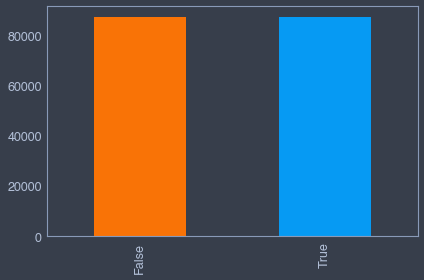

In [25]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
display(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

In [26]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(173052, 15) (1748, 15)


In [27]:
# save to pickle
pd.to_pickle(train, "../data/train.pkl")
pd.to_pickle(test, "../data/test.pkl")